Material for the book [Probability and Statistics for Data Science](https://a.co/d/cAss9mO). A free preprint, videos, code, slides and solutions to exercises are available at https://www.ps4ds.net/

Code for Examples 12.20, and Figures 12.10, 12.12, 12.13 and 12.17 

Linear models of the temperature at Versailles (Kentucky) as a function of the temperature at 133 other weather stations. The models are trained and tested using hourly temperature data from 2015 and 2016\
Topics and relevant videos: [Linear regression, ordinary least squares](https://www.youtube.com/watch?v=Ktdh6qXeakA), [coefficient error](https://www.youtube.com/watch?v=YD607IJa4hs), [training error](https://www.youtube.com/watch?v=aizK3kUkAq8), [test error](https://www.youtube.com/watch?v=jcLNsocHEBk), [ridge regression](https://www.youtube.com/watch?v=uv8H6RiFhdE), [the lasso, sparse regression](https://www.youtube.com/watch?v=GyEYOAPvOks)

Author: Carlos Fernandez-Granda\
Data source: https://www1.ncdc.noaa.gov/pub/data/uscrn/products/

In [1]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
from numpy import linalg as LA
from sklearn.linear_model import LinearRegression,Ridge,RidgeCV,Lasso,LassoCV
from numpy.random import default_rng
!pip install cartopy
import cartopy
import cartopy.crs as ccrs
# import cartopy.feature as cfeature
import urllib.request
import io

font_size = 15
font_size_ticks = 15

np.set_printoptions(precision=3)

# file_name_temperature_2015 = "../data/weather/temperatures_2015.npy"
# file_name_temperature_2016 = "../data/weather/temperatures_2016.npy"
# file_name_longitudes = "../data/weather/longitudes.npy"
# file_name_latitudes = "../data/weather/latitudes.npy"

# data_matrix_2015 = np.load(file_name_temperature_2015)
# data_matrix_2016 = np.load(file_name_temperature_2016)
# longitudes = np.load(file_name_longitudes)
# latitudes = np.load(file_name_latitudes)

# file_name_list = np.load('../data/weather/weather_station_names.npy')

# Raw GitHub URLs
url_temperature_2015 = "https://raw.githubusercontent.com/cfgranda/ps4ds/main/data/weather/temperatures_2015.npy"
url_temperature_2016 = "https://raw.githubusercontent.com/cfgranda/ps4ds/main/data/weather/temperatures_2016.npy"
url_longitudes = "https://raw.githubusercontent.com/cfgranda/ps4ds/main/data/weather/longitudes.npy"
url_latitudes = "https://raw.githubusercontent.com/cfgranda/ps4ds/main/data/weather/latitudes.npy"
url_station_names = "https://raw.githubusercontent.com/cfgranda/ps4ds/main/data/weather/weather_station_names.npy"

# Load .npy files using BytesIO
with urllib.request.urlopen(url_temperature_2015) as response:
    data_matrix_2015 = np.load(io.BytesIO(response.read()))

with urllib.request.urlopen(url_temperature_2016) as response:
    data_matrix_2016 = np.load(io.BytesIO(response.read()))

with urllib.request.urlopen(url_longitudes) as response:
    longitudes = np.load(io.BytesIO(response.read()))

with urllib.request.urlopen(url_latitudes) as response:
    latitudes = np.load(io.BytesIO(response.read()))

with urllib.request.urlopen(url_station_names) as response:
    file_name_list = np.load(io.BytesIO(response.read()))

def process_name(x):
    x = x[14:]
    x = x[:-7]
    x = x.translate(str.maketrans('','','_1234567890'))
    return x[2:] + ", " + x[:2]

In [2]:
def remove_faulty_measurements(data,verbose):
    min_val = -100 # We assume temperatures cannot be lower than -100
    for ind in range(len(data)):
        if data[ind] < min_val:
            if verbose:
                print(str(ind) + ": " + str(data[ind]))
            aux_ind = ind-1
            while aux_ind > 0:
                if data[aux_ind] > min_val:
                    data[ind] = data[aux_ind]
                    if verbose:
                        print("entry " + str(aux_ind) + " changed to " + str(data[ind]))
                    break
                else:
                    ind -= 1
    return data

verbose = False
for ind in range(data_matrix_2015.shape[1]):
    if np.mod(ind,10) == 0:
        print(str(ind) + " stations processed")
    data_matrix_2015[:,ind] = remove_faulty_measurements(data_matrix_2015[:,ind],verbose)
    data_matrix_2016[:,ind] = remove_faulty_measurements(data_matrix_2016[:,ind],verbose)

0 stations processed
10 stations processed
20 stations processed
30 stations processed
40 stations processed
50 stations processed
60 stations processed
70 stations processed
80 stations processed
90 stations processed
100 stations processed
110 stations processed
120 stations processed
130 stations processed


In [3]:
# Split into training and test data
ind_response = 55
print( "Response is " + process_name(str(file_name_list[ind_response])))
y_all = data_matrix_2015[:,ind_response]
y_2016 = data_matrix_2016[:,ind_response]
n_2016 = len(y_2016)
longitude_y = longitudes[ind_response]
latitude_y = latitudes[ind_response]

ind_X = np.hstack((np.arange(0,ind_response),np.arange(ind_response+1,data_matrix_2015.shape[1])))
XT_all = data_matrix_2015[:,ind_X]
XT_2016 = data_matrix_2016[:,ind_X]
longitudes_X = np.array(longitudes)[ind_X]
latitudes_X = np.array(latitudes)[ind_X]

d = XT_all.shape[1]

n_test = int(1e3)
n_data = data_matrix_2015.shape[0]
rng = default_rng(2023)
aux_ind = rng.permutation(n_data)
ind_test = aux_ind[:n_test]
XT_test = XT_all[ind_test,:]
y_test = y_all[ind_test]
ind_train = aux_ind[n_test:]
XT_train = XT_all[ind_train,:]
y_train = y_all[ind_train]
n_train = XT_train.shape[0]
print("Number of features",d)
print("Total number of training examples",n_train)

Response is Versailles, KY
Number of features 133
Total number of training examples 7760


In [4]:
# Computation of ordinary least squares, ridge regression and lasso estimators 
# for different number of training data
n_vals = np.logspace(np.log10(d),np.log10(n_train)).astype(int)
n_alphas = 200
n_alpha_lasso = 200
alphas_val = np.logspace(-1, 6, n_alphas)

n_len = len(n_vals)
cov_matrix_eigvals = np.zeros((d,n_len)) 

OLS_coeffs_array = np.zeros((d,n_len)) 
OLS_training_error = np.zeros(n_len)
OLS_test_error = np.zeros(n_len)
OLS_test_error_2016 = np.zeros(n_len)
ridge_coeffs_array = np.zeros((d,n_len)) 
ridge_training_error = np.zeros(n_len)
ridge_test_error = np.zeros(n_len)
ridge_test_error_2016 = np.zeros(n_len)
ridge_alphas = np.zeros(n_len) 
lasso_coeffs_array = np.zeros((d,n_len)) 
lasso_training_error = np.zeros(n_len)
lasso_test_error = np.zeros(n_len)
lasso_test_error_2016 = np.zeros(n_len)
lasso_alphas = np.zeros(n_len) 

for ind_n,n in enumerate(n_vals):
    XT_train_n = XT_train[:n,:]
    y_train_n = y_train[:n]
    cov_matrix = np.cov(XT_train_n.T,ddof=1)
    eigvals_cov_matrix,eigvecs_cov_matrix = np.linalg.eig(cov_matrix)
    cov_matrix_eigvals[:,ind_n] = np.sort(eigvals_cov_matrix)

    OLS_model_n = LinearRegression().fit(XT_train_n, y_train_n)
    OLS_coeffs_array[:,ind_n] = OLS_model_n.coef_
    OLS_training_error[ind_n] = np.sqrt(np.sum((y_train_n - OLS_model_n.predict(XT_train_n))**2) / n )
    OLS_test_error[ind_n] = np.sqrt(np.sum((y_test - OLS_model_n.predict(XT_test))**2) / n_test )
    OLS_test_error_2016[ind_n] = np.sqrt(np.sum((y_2016 - OLS_model_n.predict(XT_2016))**2) / n_2016 )
    
    ridge_model_n = RidgeCV(alphas=alphas_val).fit(XT_train_n, y_train_n)
    ridge_coeffs_array[:,ind_n] = ridge_model_n.coef_
    ridge_training_error[ind_n] = np.sqrt(np.sum((y_train_n - ridge_model_n.predict(XT_train_n))**2) / n )
    ridge_test_error[ind_n] = np.sqrt(np.sum((y_test - ridge_model_n.predict(XT_test))**2) / n_test )
    ridge_test_error_2016[ind_n] = np.sqrt(np.sum((y_2016 - ridge_model_n.predict(XT_2016))**2) / n_2016 )
    ridge_alphas[ind_n] = ridge_model_n.alpha_

    lasso_model_n = LassoCV(n_alphas=n_alpha_lasso,max_iter=100000).fit(XT_train_n, y_train_n)
    lasso_coeffs_array[:,ind_n] = lasso_model_n.coef_
    lasso_training_error[ind_n] = np.sqrt(np.sum((y_train_n - lasso_model_n.predict(XT_train_n))**2) / n )
    lasso_test_error[ind_n] = np.sqrt(np.sum((y_test - lasso_model_n.predict(XT_test))**2) / n_test )
    lasso_test_error_2016[ind_n] = np.sqrt(np.sum((y_2016 - lasso_model_n.predict(XT_2016))**2) / n_2016 )
    lasso_alphas[ind_n] = lasso_model_n.alpha_

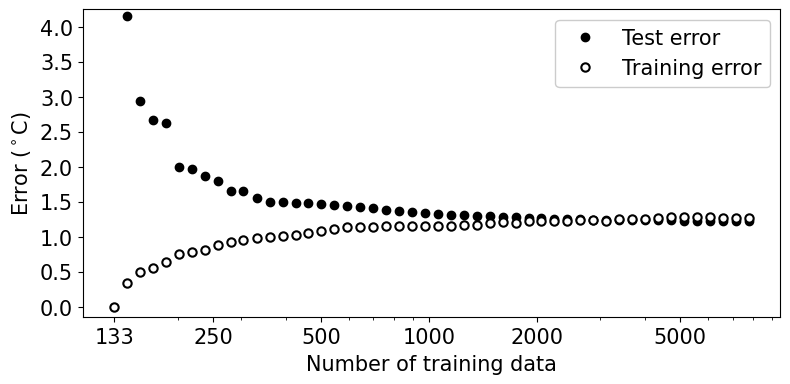

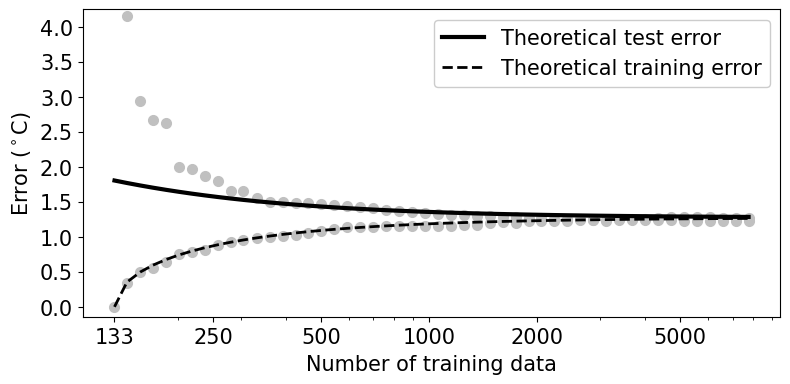

In [5]:
# Comparison between observed training and test error, and the theoretical analysis in the book
markersize = 6
xtick_vals = [133,250,500,1000,2000,5000]
sigma_est = OLS_training_error[-1]
theoretical_prediction_train = sigma_est * np.sqrt(1-d/n_vals)
theoretical_prediction_test = sigma_est * np.sqrt(1+d/(n_vals-1))
fig = plt.figure(figsize = (9,4)) 
plt.semilogx(n_vals,OLS_test_error,"o",markersize=markersize,markerfacecolor='black',markeredgecolor="black",markeredgewidth =1,label="Test error")
plt.semilogx(n_vals,OLS_training_error,"o",markersize=markersize,markerfacecolor='white',markeredgecolor="black",markeredgewidth =1.5,label="Training error")
plt.xticks(fontsize=font_size_ticks) 
plt.yticks(fontsize=font_size_ticks)
plt.ylim([-0.15,4.25])
ax = plt.gca()
ax.set_xscale('log')
ax.set_xticks(xtick_vals)
ax.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
plt.legend(fontsize=font_size,framealpha=1)
plt.xlabel(r'Number of training data',fontsize=font_size,labelpad = 5)
plt.ylabel(r'Error ($^\circ$C)',fontsize=font_size,labelpad = 5)

fig = plt.figure(figsize = (9,4)) 
plt.semilogx(n_vals,OLS_test_error,"o",markersize=markersize,markerfacecolor='silver',markeredgecolor="silver",markeredgewidth =2)
plt.semilogx(n_vals,OLS_training_error,"o",markersize=markersize,markerfacecolor='silver',markeredgecolor="silver",markeredgewidth =2)
plt.semilogx(n_vals,theoretical_prediction_test,lw=3,ls="solid",color="black",label="Theoretical test error")
plt.semilogx(n_vals,theoretical_prediction_train,lw=2,ls="dashed",color="black",label="Theoretical training error")
plt.xticks(fontsize=font_size_ticks) 
plt.yticks(fontsize=font_size_ticks)
plt.ylim([-0.15,4.25])
ax = plt.gca()
ax.set_xscale('log')
ax.set_xticks(xtick_vals)
ax.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
plt.legend(fontsize=font_size,framealpha=1)
plt.xlabel(r'Number of training data',fontsize=font_size,labelpad = 5)
plt.ylabel(r'Error ($^\circ$C)',fontsize=font_size,labelpad = 5);

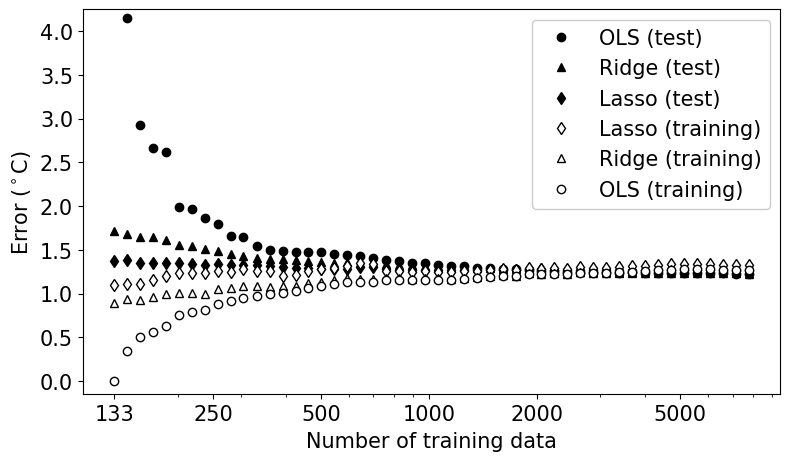

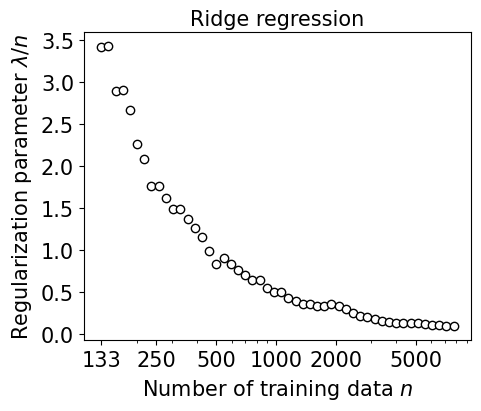

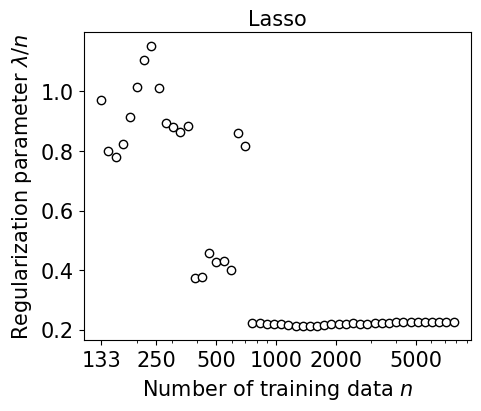

In [6]:
fig = plt.figure(figsize = (9,5)) 
plt.semilogx(n_vals,OLS_test_error,"o",markersize=markersize,markerfacecolor='black',markeredgecolor="black",markeredgewidth =1,label="OLS (test)")
plt.semilogx(n_vals,ridge_test_error,"^",markersize=markersize,markerfacecolor='black',markeredgecolor="black",markeredgewidth =1,label="Ridge (test)")
plt.semilogx(n_vals,lasso_test_error,"d",markersize=markersize,markerfacecolor='black',markeredgecolor="black",markeredgewidth =1,label="Lasso (test)")
plt.semilogx(n_vals,lasso_training_error,"d",markersize=markersize,markerfacecolor='white',markeredgecolor="black",markeredgewidth =1,label="Lasso (training)")
plt.semilogx(n_vals,ridge_training_error,"^",markersize=markersize,markerfacecolor='white',markeredgecolor="black",markeredgewidth =1,label="Ridge (training)")
plt.semilogx(n_vals,OLS_training_error,"o",markersize=markersize,markerfacecolor='white',markeredgecolor="black",markeredgewidth =1,label="OLS (training)")
plt.xticks(fontsize=font_size_ticks) 
plt.yticks(fontsize=font_size_ticks)
plt.ylim([-0.15,4.25])
#plt.xlim([1,n_train+10])
ax = plt.gca()
ax.set_xscale('log')
ax.set_xticks(xtick_vals)
ax.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
plt.legend(fontsize=font_size,framealpha=1)
plt.xlabel(r'Number of training data',fontsize=font_size,labelpad = 5)
plt.ylabel(r'Error ($^\circ$C)',fontsize=font_size,labelpad = 5)

fig = plt.figure(figsize = (5,4)) 
plt.plot(n_vals,ridge_alphas/n_vals,"o",markersize=markersize,markerfacecolor='white',markeredgecolor="black",markeredgewidth =1)
plt.xticks(fontsize=font_size_ticks) 
plt.yticks(fontsize=font_size_ticks)
ax = plt.gca()
ax.set_xscale('log')
ax.set_xticks(xtick_vals)
ax.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
plt.xlabel(r'Number of training data $n$',fontsize=font_size,labelpad = 5)
plt.ylabel(r'Regularization parameter $\lambda/n$',fontsize=font_size,labelpad = 5)
plt.title(r'Ridge regression',fontsize=font_size,pad = 5)

fig = plt.figure(figsize = (5,4)) 
plt.plot(n_vals,2*lasso_alphas,"o",markersize=markersize,markerfacecolor='white',markeredgecolor="black",markeredgewidth =1)
plt.xticks(fontsize=font_size_ticks) 
plt.yticks(fontsize=font_size_ticks)
ax = plt.gca()
ax.set_xscale('log')
ax.set_xticks(xtick_vals)
ax.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
plt.xlabel(r'Number of training data $n$',fontsize=font_size,labelpad = 5)
plt.ylabel(r'Regularization parameter $\lambda/n$',fontsize=font_size,labelpad = 5)
plt.title(r'Lasso',fontsize=font_size,pad = 5);

Largest coefficient: BowlingGreen, KY
2nd largest coefficient: Bedford, IN
3rd largest coefficient: Elkins, WV


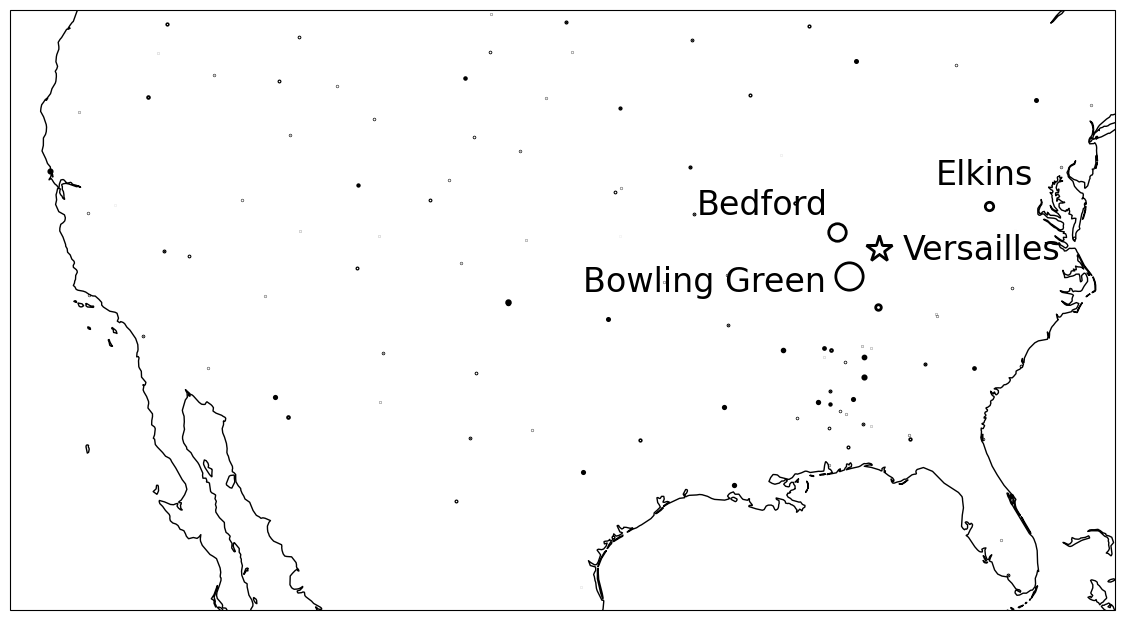

In [7]:
largest_coeff_ind = np.argsort(OLS_coeffs_array[:,-1])[-1] 
second_largest_coeff_ind = np.argsort(OLS_coeffs_array[:,-1])[-2] 
third_largest_coeff_ind = np.argsort(OLS_coeffs_array[:,-1])[-3] 

coeffs = OLS_coeffs_array[:,-1]
coeff_marker = 40
print("Largest coefficient:",process_name(file_name_list[ind_X[largest_coeff_ind]] ))
print("2nd largest coefficient:",process_name(file_name_list[ind_X[second_largest_coeff_ind]]))
print("3rd largest coefficient:",process_name(file_name_list[ind_X[third_largest_coeff_ind]]))

fig = plt.figure(figsize=(15,6))
ax = fig.add_axes([0, 0, 1, 1], projection=ccrs.LambertConformal())
ax.set_extent([-120, -77.5, 24, 45], ccrs.Geodetic())

ax.coastlines()
ax.plot(longitude_y,latitude_y, '*', markersize=20,color="black",markeredgewidth=2,
        markerfacecolor="white",transform=ccrs.Geodetic(),label='Response')
for ind in range(d):
    if coeffs[ind] > 0:
        ax.plot(longitudes_X[ind],latitudes_X[ind],'o',ms=coeff_marker*coeffs[ind],color="black",markeredgewidth=2,
                 markerfacecolor="white",transform=ccrs.Geodetic())
    else:
        ax.plot(longitudes_X[ind],latitudes_X[ind],'o',ms=-coeff_marker*coeffs[ind],markeredgecolor="black",markeredgewidth=2,
                 markerfacecolor="black",transform=ccrs.Geodetic())
plt.text(longitude_y+1,latitude_y-0.5,"Versailles",transform=ccrs.Geodetic(),fontsize=24)
plt.text(longitude_y-13.5,latitude_y-1,"Bowling Green",transform=ccrs.Geodetic(),fontsize=24)
plt.text(longitude_y-8.25,latitude_y+1.75,"Bedford",transform=ccrs.Geodetic(),fontsize=24)
plt.text(longitude_y+3,latitude_y+2,"Elkins",transform=ccrs.Geodetic(),fontsize=24)
plt.ylabel('Latitude',fontsize=font_size,labelpad=10)
plt.xlabel('Longitude',fontsize=font_size,labelpad=10);

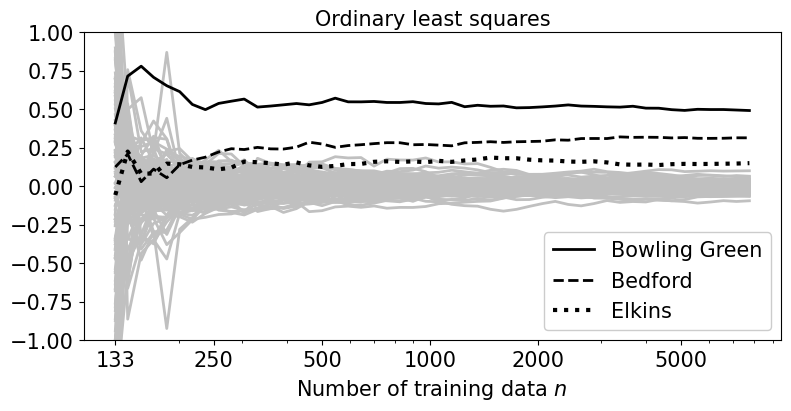

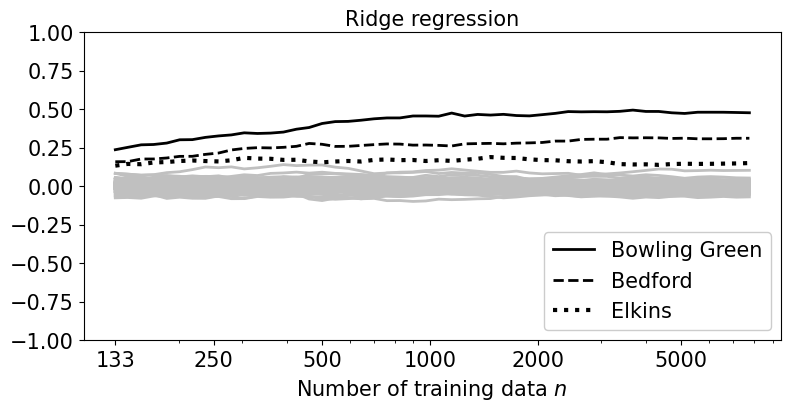

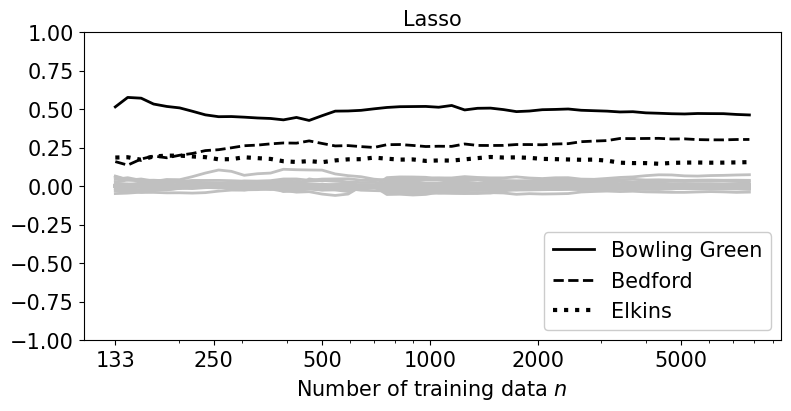

In [8]:
linewidth = 2
fig = plt.figure(figsize = (9,4)) 
for ind_feature in range(d):
    if ind_feature != largest_coeff_ind and ind_feature != second_largest_coeff_ind and ind_feature != third_largest_coeff_ind:
        plt.semilogx(n_vals,OLS_coeffs_array[ind_feature,:],lw=linewidth,color="silver")
plt.semilogx(n_vals,OLS_coeffs_array[largest_coeff_ind,:],lw=linewidth,color="black",label="Bowling Green")
plt.semilogx(n_vals,OLS_coeffs_array[second_largest_coeff_ind,:],lw=linewidth,ls="dashed",color="black",label="Bedford")
plt.semilogx(n_vals,OLS_coeffs_array[third_largest_coeff_ind,:],lw=linewidth+1,ls="dotted",color="black",label="Elkins")
plt.legend(fontsize=font_size,framealpha=1,loc="lower right")
plt.ylim([-1,1])
plt.xticks(fontsize=font_size_ticks) 
plt.yticks(fontsize=font_size_ticks)
ax = plt.gca()
ax.set_xscale('log')
ax.set_xticks(xtick_vals)
ax.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
plt.xlabel(r'Number of training data $n$',fontsize=font_size,labelpad = 5)
plt.title('Ordinary least squares',fontsize=font_size,pad = 5)

fig = plt.figure(figsize = (9,4)) 
for ind_feature in range(d):
    if ind_feature != largest_coeff_ind and ind_feature != second_largest_coeff_ind and ind_feature != third_largest_coeff_ind:
        plt.semilogx(n_vals,ridge_coeffs_array[ind_feature,:],lw=linewidth,color="silver")
plt.semilogx(n_vals,ridge_coeffs_array[largest_coeff_ind,:],lw=linewidth,color="black",label="Bowling Green")
plt.semilogx(n_vals,ridge_coeffs_array[second_largest_coeff_ind,:],lw=linewidth,ls="dashed",color="black",label="Bedford")
plt.semilogx(n_vals,ridge_coeffs_array[third_largest_coeff_ind,:],lw=linewidth+1,ls="dotted",color="black",label="Elkins")
plt.legend(fontsize=font_size,framealpha=1,loc="lower right")
plt.ylim([-1,1])
plt.xticks(fontsize=font_size_ticks) 
plt.yticks(fontsize=font_size_ticks)
ax = plt.gca()
ax.set_xscale('log')
ax.set_xticks(xtick_vals)
ax.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
plt.xlabel(r'Number of training data $n$',fontsize=font_size,labelpad = 5)
plt.title('Ridge regression',fontsize=font_size,pad = 5)

fig = plt.figure(figsize = (9,4)) 
for ind_feature in range(d):
    if ind_feature != largest_coeff_ind and ind_feature != second_largest_coeff_ind and ind_feature != third_largest_coeff_ind:
        plt.semilogx(n_vals,lasso_coeffs_array[ind_feature,:],lw=linewidth,color="silver")
plt.semilogx(n_vals,lasso_coeffs_array[largest_coeff_ind,:],lw=linewidth,color="black",label="Bowling Green")
plt.semilogx(n_vals,lasso_coeffs_array[second_largest_coeff_ind,:],lw=linewidth,ls="dashed",color="black",label="Bedford")
plt.semilogx(n_vals,lasso_coeffs_array[third_largest_coeff_ind,:],lw=linewidth+1,ls="dotted",color="black",label="Elkins")
plt.legend(fontsize=font_size,framealpha=1,loc="lower right")
plt.ylim([-1,1])
plt.xticks(fontsize=font_size_ticks) 
plt.yticks(fontsize=font_size_ticks)
ax = plt.gca()
ax.set_xscale('log')
ax.set_xticks(xtick_vals)
ax.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
plt.xlabel(r'Number of training data $n$',fontsize=font_size,labelpad = 5)
plt.title('Lasso',fontsize=font_size,pad = 5);

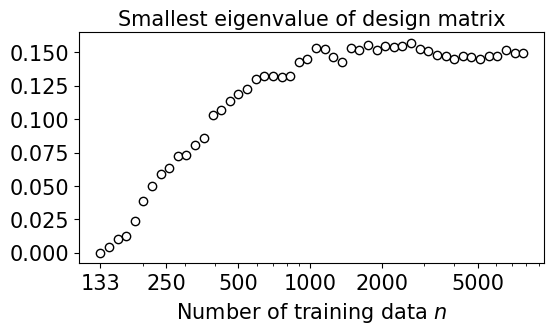

In [9]:
fig = plt.figure(figsize = (6,3)) 
plt.plot(n_vals,cov_matrix_eigvals[0,:],"o",markersize=markersize,markerfacecolor='white',markeredgecolor="black",markeredgewidth =1)
plt.xticks(fontsize=font_size_ticks) 
plt.yticks(fontsize=font_size_ticks)
ax = plt.gca()
ax.set_xscale('log')
ax.set_xticks(xtick_vals)
ax.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
plt.xlabel(r'Number of training data $n$',fontsize=font_size,labelpad = 5)
plt.title(r'Smallest eigenvalue of design matrix',fontsize=font_size,pad = 5);

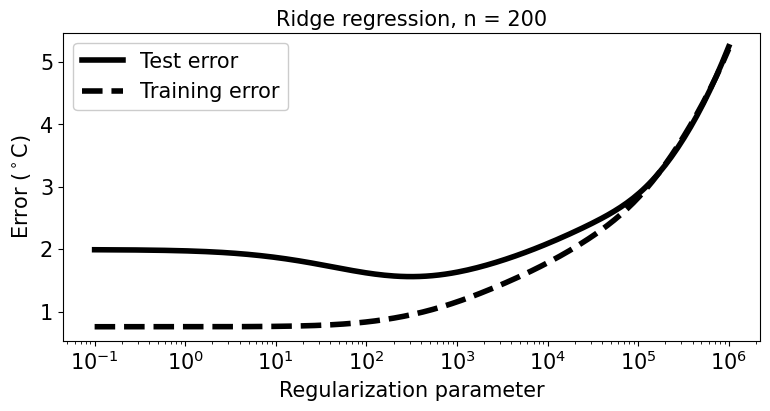

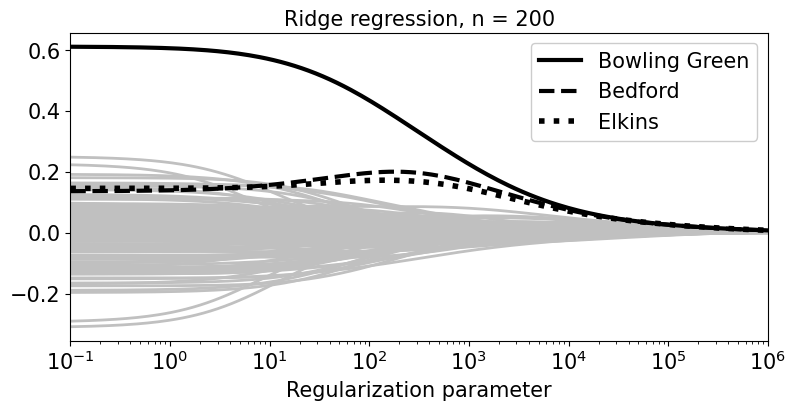

In [10]:
n = 200
alphas_val_ridge = np.logspace(-1, 6, n_alphas)
ridge_training_error_alpha = np.zeros(n_alphas) 
ridge_test_error_alpha = np.zeros(n_alphas)
ridge_coeffs_array_alpha = np.zeros((d,n_alphas)) 

for ind_alpha,alpha_val in enumerate(alphas_val_ridge):
    XT_train_n = XT_train[:n,:]
    y_train_n = y_train[:n]
    
    ridge_model_alpha = Ridge(alpha=alpha_val).fit(XT_train_n, y_train_n)
    ridge_training_error_alpha[ind_alpha] = np.sqrt(np.sum((y_train_n - ridge_model_alpha.predict(XT_train_n))**2) / n )
    ridge_test_error_alpha[ind_alpha] = np.sqrt(np.sum((y_test - ridge_model_alpha.predict(XT_test))**2) / n_test )
    ridge_coeffs_array_alpha[:,ind_alpha] = ridge_model_alpha.coef_

fig = plt.figure(figsize = (9,4)) 
plt.semilogx(alphas_val,ridge_test_error_alpha,lw=4,color="black",label="Test error")
plt.semilogx(alphas_val,ridge_training_error_alpha,ls="dashed",lw=4,color="black",label="Training error")
plt.xticks(fontsize=font_size_ticks) 
plt.yticks(fontsize=font_size_ticks)
plt.legend(fontsize=font_size_ticks,framealpha=1)
plt.xlabel(r'Regularization parameter',fontsize=font_size,labelpad = 5)
plt.ylabel(r'Error ($^\circ$C)',fontsize=font_size,labelpad = 5)
plt.title('Ridge regression, n = '+str(n),fontsize=font_size,pad = 5);

fig = plt.figure(figsize = (9,4)) 
for ind_feature in range(d):
    if ind_feature != largest_coeff_ind and ind_feature != second_largest_coeff_ind and ind_feature != third_largest_coeff_ind:
        plt.semilogx(alphas_val_ridge,ridge_coeffs_array_alpha[ind_feature,:],lw=2,color="silver")
plt.semilogx(alphas_val_ridge,ridge_coeffs_array_alpha[largest_coeff_ind,:],lw=3,color="black",label="Bowling Green")
plt.semilogx(alphas_val_ridge,ridge_coeffs_array_alpha[second_largest_coeff_ind,:],lw=3,ls="dashed",color="black",label="Bedford")
plt.semilogx(alphas_val_ridge,ridge_coeffs_array_alpha[third_largest_coeff_ind,:],lw=4,ls="dotted",color="black",label="Elkins")
plt.legend(fontsize=font_size_ticks,framealpha=1)
plt.xticks(fontsize=font_size_ticks) 
plt.yticks(fontsize=font_size_ticks)
plt.xlim([alphas_val_ridge[0],alphas_val_ridge[-1]])
plt.xlabel(r'Regularization parameter',fontsize=font_size,labelpad = 5)
plt.title('Ridge regression, n = '+str(n),fontsize=font_size,pad = 5);

In [ ]:
n = 200
alphas_lasso_val = np.logspace(-4, 2.5, n_alphas)
lasso_training_error_alpha = np.zeros(n_alphas) 
lasso_test_error_alpha = np.zeros(n_alphas)
lasso_coeffs_array_alpha = np.zeros((d,n_alphas)) 

for ind_alpha,alpha_val in enumerate(alphas_lasso_val):
    XT_train_n = XT_train[:n,:]
    y_train_n = y_train[:n]
    
    lasso_model_alpha = Lasso(alpha=alpha_val,max_iter=100000).fit(XT_train_n, y_train_n) # max_iter=100000
    lasso_training_error_alpha[ind_alpha] = np.sqrt(np.sum((y_train_n - lasso_model_alpha.predict(XT_train_n))**2) / n )
    lasso_test_error_alpha[ind_alpha] = np.sqrt(np.sum((y_test - lasso_model_alpha.predict(XT_test))**2) / n_test )
    lasso_coeffs_array_alpha[:,ind_alpha] = lasso_model_alpha.coef_

In [ ]:
fig = plt.figure(figsize = (9,4)) 
plt.semilogx(2*n*alphas_lasso_val,lasso_test_error_alpha,lw=4,color="black",label="Test error")
plt.semilogx(2*n*alphas_lasso_val,lasso_training_error_alpha,ls="dashed",lw=4,color="black",label="Training error")
plt.xticks(fontsize=font_size_ticks) 
plt.yticks(fontsize=font_size_ticks)
plt.legend(fontsize=font_size,framealpha=1)
plt.xlabel(r'Regularization parameter',fontsize=font_size,labelpad = 5)
plt.ylabel(r'Error ($^\circ$C)',fontsize=font_size,labelpad = 5)
plt.title('Lasso, n = '+str(n),fontsize=font_size,pad = 5);

plt.xticks(fontsize=font_size_ticks) 
plt.yticks(fontsize=font_size_ticks)

fig = plt.figure(figsize = (9,4)) 
for ind_feature in range(d):
    if ind_feature != largest_coeff_ind and ind_feature != second_largest_coeff_ind and ind_feature != third_largest_coeff_ind:
        plt.semilogx(2*n*alphas_lasso_val,lasso_coeffs_array_alpha[ind_feature,:],lw=2,color="silver")
plt.semilogx(2*n*alphas_lasso_val,lasso_coeffs_array_alpha[largest_coeff_ind,:],lw=3,color="black",label="Bowling Green")
plt.semilogx(2*n*alphas_lasso_val,lasso_coeffs_array_alpha[second_largest_coeff_ind,:],lw=3,ls="dashed",color="black",label="Bedford")
plt.semilogx(2*n*alphas_lasso_val,lasso_coeffs_array_alpha[third_largest_coeff_ind,:],lw=3,ls="dotted",color="black",label="Elkins")
plt.legend(fontsize=font_size,framealpha=1,loc="lower right")
plt.xticks(fontsize=font_size_ticks) 
plt.yticks(fontsize=font_size_ticks)
plt.xlim([2*n*alphas_lasso_val[0],2*n*alphas_lasso_val[-1]])
plt.ylim([-0.4,0.65])
plt.xlabel(r'Regularization parameter',fontsize=font_size,labelpad = 5)
plt.title('Lasso, n = '+str(n),fontsize=font_size,pad = 5);